In [23]:
pip install nolds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 1.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install hurst

Note: you may need to restart the kernel to use updated packages.


In [86]:
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_excel("witn_new_rat_ag_num_cat_catnum.xlsx")

# Фильтрация по _ro_type (исключаем строки, начинающиеся на "T")
df_cur = df.loc[~df["_ro_type"].str.startswith("T", na=False)]
print(len(df_cur))
# Фильтрация по нужным колонкам
columns_needed = ["rating_numeric_cat", "_date", "identifier", "_ro_type", "agency"]
df_filtered = df_cur[columns_needed].copy()

# Добавляем колонки "год" и "полугодие"
df_filtered["_year"] = df_filtered["_date"].dt.year
df_filtered["_half"] = df_filtered["_date"].dt.month.apply(lambda x: "H1" if x <= 6 else "H2")
df_filtered["_half_year"] = df_filtered["_year"].astype(str) + "-" + df_filtered["_half"]

# Сортируем данные по компании и дате
df_filtered = df_filtered.sort_values(by=["identifier", "_date"])

# Функция для заполнения пропущенных рейтингов
def fill_missing_ratings(df):
    df["rating_numeric_cat"] = df["rating_numeric_cat"].ffill()  # Заполняем пропуски последним известным значением
    return df

# Применяем функцию для каждой компании, убираем дублирующийся индекс
df_filled = df_filtered.groupby("identifier", group_keys=False).apply(fill_missing_ratings).reset_index(drop=True)

# Выбираем последний рейтинг в каждом полугодии
df_half_year = df_filled.groupby(["identifier", "_half_year"], as_index=False).last()

# Оставляем только нужные колонки
df_half_year = df_half_year[["identifier", "_half_year", "rating_numeric_cat", "_ro_type", "agency"]]
df_half_year = df_half_year[(df_half_year["_ro_type"] == "CBNK - кредитная организация") & (df_half_year["agency"] == "Expert RA")]

# Выводим результат
print(df_half_year)


6784
      identifier _half_year  rating_numeric_cat                      _ro_type  \
6      106000547    2017-H1                   4  CBNK - кредитная организация   
7      106000547    2017-H2                   5  CBNK - кредитная организация   
8      106000547    2022-H1                   5  CBNK - кредитная организация   
39     274062111    2023-H2                   3  CBNK - кредитная организация   
41     274062111    2024-H2                   3  CBNK - кредитная организация   
...          ...        ...                 ...                           ...   
5603  8602190258    2022-H1                   3  CBNK - кредитная организация   
5604  8602190258    2023-H1                   3  CBNK - кредитная организация   
5623  8622002375    2018-H2                   6  CBNK - кредитная организация   
5674  9703077050    2024-H2                   4  CBNK - кредитная организация   
5729  9721194461    2024-H2                   4  CBNK - кредитная организация   

         agency  
6   

/var/folders/0w/pg719rr9519435t25t6yf2hm0000gn/T/ipykernel_75590/3108210756.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df_filtered.groupby("identifier", group_keys=False).apply(fill_missing_ratings).reset_index(drop=True)


In [3]:
import nolds

# Функция для расчета параметра Херста с DFA
def calculate_dfa(series):
    if len(series) < 5:  # Проверяем, хватает ли данных
        return None
    return nolds.dfa(series.values)

# Группируем данные по identifier и считаем DFA
df_hurst = df_half_year.groupby("identifier")["rating_numeric_cat"].apply(calculate_dfa).reset_index()
df_hurst = df_hurst.rename(columns={"rating_numeric_cat": "H_DFA"})

print(df_hurst.head(20))

/opt/anaconda3/lib/python3.11/site-packages/nolds/measures.py:2160: RuntimeWarning: choosing nvals = [4, 5] , DFA with less than ten data points is extremely unreliable
  warnings.warn(msg.format(nvals), RuntimeWarning)
/opt/anaconda3/lib/python3.11/site-packages/nolds/measures.py:2160: RuntimeWarning: choosing nvals = [8, 9] , DFA with less than ten data points is extremely unreliable
  warnings.warn(msg.format(nvals), RuntimeWarning)


    identifier      H_DFA
0    106000547        NaN
1    274062111        NaN
2    276016368        NaN
3    411006129        NaN
4    541012405        NaN
5    541016015   0.523755
6    901001063        NaN
7   1001011328        NaN
8   1101300820   0.390158
9   1102011300        NaN
10  1300034972        NaN
11  1326021671   1.726301
12  1326024785   2.606284
13  1435126628        NaN
14  1435138944  11.395824
15  1626000087        NaN
16  1627000724        NaN
17  1644004905        NaN
18  1650002455        NaN
19  1650025163        NaN


/opt/anaconda3/lib/python3.11/site-packages/nolds/measures.py:51: RuntimeWarning: RANSAC did not reach consensus, using numpy's polyfit
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/nolds/measures.py:2160: RuntimeWarning: choosing nvals = [6, 7] , DFA with less than ten data points is extremely unreliable
  warnings.warn(msg.format(nvals), RuntimeWarning)
/opt/anaconda3/lib/python3.11/site-packages/nolds/measures.py:51: RuntimeWarning: RANSAC did not reach consensus, using numpy's polyfit
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/nolds/measures.py:2160: RuntimeWarning: choosing nvals = [3, 4] , DFA with less than ten data points is extremely unreliable
  warnings.warn(msg.format(nvals), RuntimeWarning)
/opt/anaconda3/lib/python3.11/site-packages/nolds/measures.py:51: RuntimeWarning: RANSAC did not reach consensus, using numpy's polyfit
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/nolds/measures.py:2160: RuntimeWarning: choosing nvals = 

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Функция для расчета параметра Херста вручную
def hurst_exponent(ts):
    ts = np.array(ts)
    N = len(ts)
    print(ts, N)
    if N < 10:  # Проверка на достаточное количество точек
        return np.nan
    
    # Вычисляем среднее и центрируем ряд
    mean_ts = np.mean(ts)
    dev = ts - mean_ts

    # Кумулятивная сумма
    Z = np.cumsum(dev)
    
    # Размах (R) - разница между max и min кумулятивной суммы
    R = np.max(Z) - np.min(Z)
    if R == 0 and S == 0:
        R = 0.0001
        S = 0.00009
        # return (np.log(RS_ratio) / np.log(np.pi * (N / 2))) * correction_factor
        return np.nan

    # Среднеквадратическое отклонение (S)
    S = np.std(ts)
    
    if S == 0:
        return np.nan
    
    # Вычисляем R/S
    RS = R / S
    
    # Параметр Херста по логарифмическому масштабу
    H = np.log(RS) / np.log(N)
    
    return H
    
def hurst_exponent_neyman(ts):
    ts = np.array(ts)
    N = len(ts)

    if N < 3:
        return np.nan  # Недостаточно данных

    # Вычисление размаха R и стандартного отклонения S
    mean_ts = np.mean(ts)
    dev = ts - mean_ts
    Z = np.cumsum(dev)
    
    R = np.max(Z) - np.min(Z)
    S = np.std(ts)

    if R == 0 or S == 0:
        R = 0.001
        S = 0.0009
        RS_ratio = R / S
        return np.nan
    # Поправка Неймана
    RS_ratio = R / S
    correction_factor = (-0.0011 * np.log(N) + 1.0136)
    
    H_T = (np.log(RS_ratio) / np.log(np.pi * (N / 2))) * correction_factor

    return H_T
    
# Группируем данные по identifier и применяем Hurst
# hurst_results = (
#     df_half_year.groupby("identifier")["rating_numeric_cat"]
#     .apply(hurst_exponent)
#     .reset_index()
# )
hurst_ = []
# for inn in df_half_year["identifier"].unique():
#     temp_ = df_half_year[df_half_year["identifier"] == inn]
#     if len(temp_) >= 10: 
#         hurst_.append(hurst_exponent(temp_["rating_numeric_cat"].values))
#     elif len(temp_) >= 5 and len(temp_) < 10:
#         hurst_.append(hurst_exponent_neyman(temp_["rating_numeric_cat"].values))
counter = 0
check = pd.DataFrame()
for inn in df_half_year["identifier"].unique():
    temp_ = df_half_year[df_half_year["identifier"] == inn]
    if len(temp_) >= 10:
        check = pd.concat([check, temp_])
        rating_ = temp_["rating_numeric_cat"].values
        # temp_["untrated"] = check["rating_numeric_cat"].apply(lambda x: (x - check["rating_numeric_cat"].mean()
# Заменим -inf на NaN для корректной визуализации
# hurst_results.replace(-np.inf, np.nan, inplace=True)

# # Удаляем NaN перед построением графиков
# hurst_results = df_hurst.dropna()
# hurst_results.columns = ["identifier", "hurst_exponent"]
# hurst_ = hurst_results["hurst_exponent"]
# print(hurst_results.head(20))
# plt.plot(pd.DataFrame(hurst_).dropna())
# plt.title(pd.DataFrame(hurst_).dropna().mean())

In [10]:
check_con = []
for inn in check["identifier"].unique():
    temp_ = check[check["identifier"] == inn]
    if len(temp_) >= 10:
        # check = pd.concat([check, temp_])
        # rating_ = temp_["rating_numeric_cat"].values
        temp_["untrated"] = temp_["rating_numeric_cat"].apply(lambda x: (x - temp_["rating_numeric_cat"].mean()))
        check_con.append(list(temp_["untrated"].values))

/var/folders/0w/pg719rr9519435t25t6yf2hm0000gn/T/ipykernel_75590/1218911625.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_["untrated"] = temp_["rating_numeric_cat"].apply(lambda x: (x - temp_["rating_numeric_cat"].mean()))
/var/folders/0w/pg719rr9519435t25t6yf2hm0000gn/T/ipykernel_75590/1218911625.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_["untrated"] = temp_["rating_numeric_cat"].apply(lambda x: (x - temp_["rating_numeric_cat"].mean()))
/var/folders/0w/pg719rr9519435t25t6yf2hm0000

In [12]:
check_con

[[-0.5999999999999996,
  -0.5999999999999996,
  -0.5999999999999996,
  -0.5999999999999996,
  0.40000000000000036,
  0.40000000000000036,
  0.40000000000000036,
  0.40000000000000036,
  0.40000000000000036,
  0.40000000000000036],
 [-0.18181818181818166,
  0.8181818181818183,
  0.8181818181818183,
  -0.18181818181818166,
  -0.18181818181818166,
  -0.18181818181818166,
  -0.18181818181818166,
  -0.18181818181818166,
  -0.18181818181818166,
  -0.18181818181818166,
  -0.18181818181818166],
 [-0.7999999999999998,
  -0.7999999999999998,
  0.20000000000000018,
  0.20000000000000018,
  0.20000000000000018,
  0.20000000000000018,
  0.20000000000000018,
  0.20000000000000018,
  0.20000000000000018,
  0.20000000000000018],
 [-1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [-0.7999999999999998,
  -0.7999999999999998,
  0.20000000000000018,
  0.20000000000000018,
  0.20000000000000018,
  0.20000000000000018,
  0.20000000000000018,
  0.20000000000000018,
  0.20000000000000018,
  0.2000000

In [16]:
full_ = []
for i in check_con:
        full_.append(i)

In [18]:
len(full_)

8

In [22]:
full_plot = []
for i in full_:
    for j in i:
        full_plot.append(j)

In [24]:
full_plot

[-0.5999999999999996,
 -0.5999999999999996,
 -0.5999999999999996,
 -0.5999999999999996,
 0.40000000000000036,
 0.40000000000000036,
 0.40000000000000036,
 0.40000000000000036,
 0.40000000000000036,
 0.40000000000000036,
 -0.18181818181818166,
 0.8181818181818183,
 0.8181818181818183,
 -0.18181818181818166,
 -0.18181818181818166,
 -0.18181818181818166,
 -0.18181818181818166,
 -0.18181818181818166,
 -0.18181818181818166,
 -0.18181818181818166,
 -0.18181818181818166,
 -0.7999999999999998,
 -0.7999999999999998,
 0.20000000000000018,
 0.20000000000000018,
 0.20000000000000018,
 0.20000000000000018,
 0.20000000000000018,
 0.20000000000000018,
 0.20000000000000018,
 0.20000000000000018,
 -1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.7999999999999998,
 -0.7999999999999998,
 0.20000000000000018,
 0.20000000000000018,
 0.20000000000000018,
 0.20000000000000018,
 0.20000000000000018,
 0.20000000000000018,
 0.20000000000000018,
 0.20000000000000018,
 0.09090909090909083,
 -

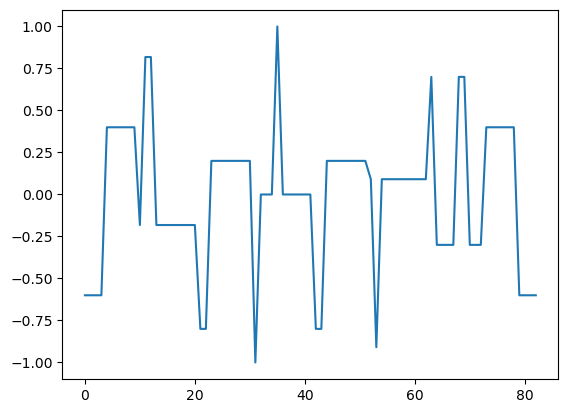

In [26]:
plt.plot(full_plot)

In [44]:
R = np.max(full_plot) - np.min(full_plot)

In [46]:
S = np.array(full_plot).std()

In [48]:
R

2.0

In [50]:
S

0.4200610188815307

In [54]:
# Вычисляем R/S
RS = R / S

# Параметр Херста по логарифмическому масштабу
H = np.log(RS) / np.log(len(full_plot))

In [56]:
H

0.35314749145117746

In [34]:
Z = np.cumsum(full_plot)

In [36]:
R = np.max(Z) - np.min(Z)
S = np.std(Z)

In [38]:
R

4.800000000000008

In [40]:
S

0.9187624076063041

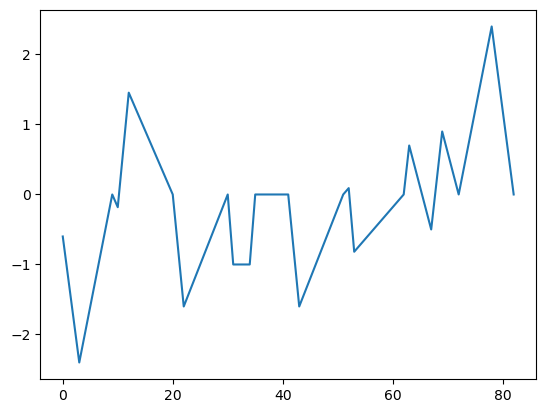

In [42]:
plt.plot(Z)

In [58]:
import math

In [62]:
len(Z)

83

In [ ]:
for i in len(Z):
    temp_ = Z[1: 

In [27]:
counter

8

In [8]:
df_half_year[df_half_year["identifier"] == 2539013067]

,identifier,_half_year,rating_numeric_cat,_ro_type,agency
633,2539013067,2017-H2,4,CBNK - кредитная организация,Expert RA
634,2539013067,2018-H1,4,CBNK - кредитная организация,Expert RA
635,2539013067,2019-H1,4,CBNK - кредитная организация,Expert RA
636,2539013067,2020-H1,4,CBNK - кредитная организация,Expert RA
637,2539013067,2021-H1,4,CBNK - кредитная организация,Expert RA
638,2539013067,2022-H1,4,CBNK - кредитная организация,Expert RA
639,2539013067,2023-H1,3,CBNK - кредитная организация,Expert RA
641,2539013067,2024-H1,3,CBNK - кредитная организация,Expert RA


Check DFA

In [10]:
len(temp_)

1

In [68]:
check["identifier"].unique()

array([ 541016015, 1835047032, 3803202031, 3906098008, 5617000264,
       7727065444, 7735057951, 7750004305])

In [70]:
check.head(10)

,identifier,_half_year,rating_numeric_cat,_ro_type,agency
76,541016015,2017-H1,5,CBNK - кредитная организация,Expert RA
77,541016015,2017-H2,5,CBNK - кредитная организация,Expert RA
78,541016015,2018-H2,5,CBNK - кредитная организация,Expert RA
79,541016015,2019-H1,5,CBNK - кредитная организация,Expert RA
80,541016015,2019-H2,6,CBNK - кредитная организация,Expert RA
81,541016015,2020-H2,6,CBNK - кредитная организация,Expert RA
82,541016015,2021-H2,6,CBNK - кредитная организация,Expert RA
83,541016015,2022-H2,6,CBNK - кредитная организация,Expert RA
84,541016015,2023-H2,6,CBNK - кредитная организация,Expert RA
85,541016015,2024-H2,6,CBNK - кредитная организация,Expert RA


In [80]:
check["identifier", "half_year"

TypeError: _LocationIndexer.__call__() takes from 1 to 2 positional arguments but 4 were given

In [90]:
test_ = check[["identifier", "_half_year", "rating_numeric_cat"]]
df = pd.DataFrame(test_).set_index("identifier")  # Убираем год из индексов

# 🔹 Считаем корреляционную матрицу
corr_matrix = df.corr(method="pearson")  # "pearson" = линейная корреляция

# 🔹 Визуализируем
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Корреляционная матрица рейтингов компаний")
plt.show()

ValueError: could not convert string to float: '2017-H1'